In [1]:
%load_ext dotenv
%dotenv

In [2]:
from langgraph.graph import START, END , StateGraph, MessagesState
from typing_extensions import TypedDict
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage, BaseMessage, AIMessage, RemoveMessage, SystemMessage
from langchain_core.runnables import Runnable
from langgraph.checkpoint.memory import InMemorySaver
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

In [3]:
class State(MessagesState):
    Summary:str

In [4]:
import os
os.environ["OPENAI_API_KEY"] = "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"

In [5]:
import openai
openai.api_key = os.getenv("OPENAI_API_KEY")

In [6]:
os.environ["OPENAI_API_BASE"] = "https://api.groq.com/openai/v1"
chat = ChatOpenAI(
    model_name="llama3-70b-8192", 
    model_kwargs={"seed": 365},
    temperature=0,
    max_completion_tokens=100)

C:\Users\hp\.conda\envs\langgraph_env\Lib\site-packages\IPython\core\interactiveshell.py:3639: UserWarning: Parameters {'seed'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  if await self.run_code(code, result, async_=asy):


In [7]:
def chatbot(state:State) -> State:
    print(f"\n----> ENTERING CHATBOT:")
    system_message = f'''
    Here's a Quick Summary of whats been discussed so far:
    {state.get("summary","")}
    keep this in mind as you answer the next question.
    '''
    response = chat.invoke([SystemMessage(system_message)] + state["messages"])
    response.pretty_print()
    return State(messages = [response])

In [8]:
def ask_question(state:State) -> State:
    print(f"\n----> ENTERING CHATBOT:")
    print("WHAT IS YOUR QUESTION??")
    return State(messages = [HumanMessage(input())])

In [9]:
def summarize_message(state:State)->State:
    print(f"\n----> ENTERING SUMMARIZE_MESSAGES:")

    new_conversation = ""
    for i in state["messages"]:
        new_conversation += f"{i.type}:{i.content}\n\n"
    
    summary_instruction = f'''
    You are a helpful assistant. Your job is to read the provided text and generate a clear, concise summary. 
    Focus only on the core points and avoid unnecessary repetition or filler.
    Instructions:
    - Summarize the input in 3 to 5 sentences.
    - Avoid copying full sentences from the original text.
    - Use your own words to rewrite the key information.
    - Ensure the summary is easy to understand.

    previous summary:
    {state.get("summary","")}
    New conversation:
    {new_conversation}
    '''
    print(summary_instruction)
    summary = chat.invoke([HumanMessage(summary_instruction)])
    remove_messages = [RemoveMessage(id=i.id) for i in state["messages"][:]]
    return State(message = remove_messages , summary = summary.content)


In [10]:
graph = StateGraph(State)

In [11]:
graph.add_node("ask_question",ask_question)
graph.add_node("chatbot",chatbot)
graph.add_node("summarize_message", summarize_message)

graph.add_edge(START,"ask_question")
graph.add_edge("ask_question","chatbot")
graph.add_edge("chatbot", "summarize_message")
graph.add_edge("summarize_message", END)
#graph.add_conditional_edges(source="ask_another_question",path = routing_function)

In [14]:
db_path = r"C:\Users\hp\Desktop\Tech Mango\Database\langgraph.db"
connect = sqlite3.connect(database = db_path, check_same_thread = False) 

In [15]:
checkpointer = SqliteSaver(connect)

In [16]:
compiled = graph.compile(checkpointer)

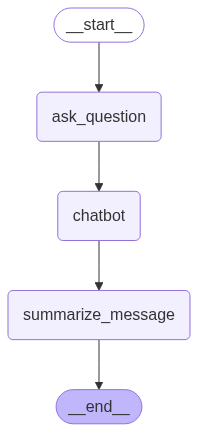

In [17]:
compiled

In [18]:
config_1 = {"configurable":{"thread_id":"1"}}

In [19]:
compiled.invoke(State(),config_1)


----> ENTERING CHATBOT:
WHAT IS YOUR QUESTION??


 who is father of python?



----> ENTERING CHATBOT:
================================== Ai Message ==================================

The father of Python is Guido van Rossum. He is a Dutch computer programmer who created the Python programming language in the late 1980s and early 1990s.

----> ENTERING SUMMARIZE_MESSAGES:

    You are a helpful assistant. Your job is to read the provided text and generate a clear, concise summary. 
    Focus only on the core points and avoid unnecessary repetition or filler.
    Instructions:
    - Summarize the input in 3 to 5 sentences.
    - Avoid copying full sentences from the original text.
    - Use your own words to rewrite the key information.
    - Ensure the summary is easy to understand.

    previous summary:
    
    New conversation:
    human:who is father of python?

ai:The father of Python is Guido van Rossum. He is a Dutch computer programmer who created the Python programming language in the late 1980s and early 1990s.


    


{'messages': [HumanMessage(content='who is father of python?', additional_kwargs={}, response_metadata={}, id='5a659784-c279-44a4-ad98-e1d698921b38'),
  AIMessage(content='The father of Python is Guido van Rossum. He is a Dutch computer programmer who created the Python programming language in the late 1980s and early 1990s.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 48, 'total_tokens': 86, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'queue_time': 0.053806889, 'prompt_time': 0.001104511, 'completion_time': 0.130282223, 'total_time': 0.131386734}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'id': 'chatcmpl-1e363d46-c5d7-4926-bc1a-5180d667ed19', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--30675cfb-d5e4-4ab3-bd01-0ab94ac1ff46-0', usage_metadata={'input_tokens': 48, 'output_tokens': 38, 'total_tokens': 86, 'input_token_details': {}, 'outp